In [1]:
import numpy as np

In [2]:
collision = np.load('.data/Time_series_colisao.npz')
display(collision.keys())
spreading = np.load('.data/Time_series_espalhamento.npz')
display(spreading.keys())

KeysView(NpzFile '.data/Time_series_colisao.npz' with keys: TS, Re, We, B)

KeysView(NpzFile '.data/Time_series_espalhamento.npz' with keys: TS, Re, We, Fr, V0...)

# Colisão | Collision

In [3]:
collision_timesteps_raw = collision['TS']
display(collision_timesteps_raw.shape)

(72, 1000, 5)

## Separando por componentes

In [4]:
components_collision: list[dict] = list()
for cmpnt in range(5):
    components_collision.append({
        "original": collision_timesteps_raw[:, :, cmpnt].T
    })

## Abordagem 1: _Autoencoder_

Escolhendo forma de definir escala dos dados.

`MaxAbsScaler`: mantém distribuição dos dados, mas altera a escala de forma que o maior valor tenha módulo igual a 1.

In [5]:
from typing import Literal
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer


chosen_scaler: Literal[
    'StandardScaler',
    'MinMaxScaler',
    'RobustScaler',
    'MaxAbsScaler',
    'QuantileTransformer',
    'PowerTransformer',
    'Normalizer'
] = 'MaxAbsScaler'
for component_dict in components_collision:
    scaler = eval(chosen_scaler)()
    scaled_data = scaler.fit_transform(component_dict["original"])
    component_dict["autoencoder"] = {
        "scaler": scaler,
        "scaled": scaled_data
    }

Definindo arquitetura da Rede Autoencoder

In [6]:
from torch.nn import Module, Linear
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torch import Tensor
import torch

def scheduler(epoch):
    power = - 0.025 * epoch
    if epoch < 25:
        return 0.1
    if epoch < 100:
        return 0.1 * np.e ** power
    else:
        return 0.008

class Autoencoder(Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Linear(72, 27)
        self.latent = Linear(27, 9)
        self.decoder = Linear(9, 27)
        self.output = Linear(27, 72)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        x = self.output(x)
        return x


def generate_autoencoder_collision():
    autoencoder = Autoencoder()
    optimizer = Adam(autoencoder.parameters(), lr=0.1)
    my_lr_scheduler = LambdaLR(optimizer, lr_lambda=scheduler)
    loss_fn = torch.nn.L1Loss()
    return autoencoder, optimizer, loss_fn, my_lr_scheduler


def train_autoencoder(autoencoder, optimizer, loss_fn, my_lr_scheduler, data):
    batch_size = 15
    for epoch in range(150):
        if epoch > 100:
            batch_size = 10
        batch_permutation = np.random.permutation(data.shape[0])
        batches = np.array_split(data[batch_permutation], data.shape[0] // batch_size)
        autoencoder.train()
        for batch in batches:
            batch = torch.tensor(batch, dtype=torch.float32)
            optimizer.zero_grad()
            y = autoencoder(batch)
            loss = loss_fn(y, batch)
            loss.backward()
            optimizer.step()
        autoencoder.eval()
        with torch.no_grad():
            data_reconstruct = autoencoder(torch.tensor(data, dtype=torch.float32))
            mape = torch.mean(torch.abs(data_reconstruct - torch.tensor(data, dtype=torch.float32)) / torch.tensor(data, dtype=torch.float32))
            print(f'Epoch {epoch}, Loss {loss.item()}, MAPE {mape.item()}')
        my_lr_scheduler.step()
    autoencoder.eval()

Treinando rede autoencoder

In [7]:
permutation_idx = np.random.permutation(collision_timesteps_raw.shape[1])
for component in components_collision:
    autoencoder, optimizer, loss_fn, my_lr_scheduler = generate_autoencoder_collision()
    component["autoencoder"]["training_data"] = component["autoencoder"]["scaled"][permutation_idx[:666]]
    train_autoencoder(autoencoder, optimizer, loss_fn, my_lr_scheduler, component["autoencoder"]["training_data"])
    component["autoencoder"]["model"] = autoencoder

Epoch 0, Loss 0.07862363010644913, MAPE 0.14953503012657166
Epoch 1, Loss 0.06409329921007156, MAPE 0.09152277559041977
Epoch 2, Loss 0.049912791699171066, MAPE 0.07719963788986206
Epoch 3, Loss 0.06185785308480263, MAPE 0.0731765404343605
Epoch 4, Loss 0.04123508185148239, MAPE 0.061537113040685654
Epoch 5, Loss 0.049081724137067795, MAPE 0.06595994532108307
Epoch 6, Loss 0.04276039078831673, MAPE 0.056657060980796814
Epoch 7, Loss 0.035952601581811905, MAPE 0.054483529180288315
Epoch 8, Loss 0.03608857840299606, MAPE 0.055515822023153305
Epoch 9, Loss 0.047724366188049316, MAPE 0.06062284857034683
Epoch 10, Loss 0.03293216601014137, MAPE 0.04742431640625
Epoch 11, Loss 0.03245837613940239, MAPE 0.046102896332740784
Epoch 12, Loss 0.052313853055238724, MAPE 0.06657528132200241
Epoch 13, Loss 0.02867073193192482, MAPE 0.04697727411985397
Epoch 14, Loss 0.03045981004834175, MAPE 0.043418001383543015
Epoch 15, Loss 0.0308891162276268, MAPE 0.04667670652270317
Epoch 16, Loss 0.02566111087

Testando rede autoencoder

In [8]:
for component in components_collision:
    component["autoencoder"]["testing_data_scaled"] =\
        component["autoencoder"]["scaled"][permutation_idx[666:]]
    component["autoencoder"]["prediction_scaled"] =\
        component["autoencoder"]["model"](torch.tensor(component["autoencoder"]["testing_data_scaled"], dtype=torch.float32)).detach().numpy()
    component["autoencoder"]["testing_data_unscaled"] =\
        component["autoencoder"]["scaler"].inverse_transform(component["autoencoder"]["testing_data_scaled"])
    component["autoencoder"]["prediction_unscaled"] =\
        component["autoencoder"]["scaler"].inverse_transform(component["autoencoder"]["prediction_scaled"])

Estatísticas de erro médio quadrático e erro médio percentual

Estatísticas sobre esses erros: mínimo obtido para um determinado timestep, máximo e média.

In [9]:
import pandas as pd
from keras.losses import mean_squared_error, mean_absolute_percentage_error

pd.set_option('display.float_format', '{:.4f}'.format)

columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    component["autoencoder"]["mse_loss"] =\
        mean_squared_error(component["autoencoder"]["testing_data_unscaled"], component["autoencoder"]["prediction_unscaled"])
    component["autoencoder"]["mape_loss"] =\
        mean_absolute_percentage_error(component["autoencoder"]["testing_data_unscaled"], component["autoencoder"]["prediction_unscaled"])
    result_df.loc[cmpnt, ("MSE", "min")] = np.min(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "max")] = np.max(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "mean")] = np.mean(component["autoencoder"]["mse_loss"])
    result_df.loc[cmpnt, ("MAPE", "min")] = np.min(component["autoencoder"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "max")] = np.max(component["autoencoder"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "mean")] = np.mean(component["autoencoder"]["mape_loss"])

results = {
    "collision": {
        "autoencoder": {
            "stats": result_df
        }
    }
}

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(results["collision"]["autoencoder"]["stats"])

2024-04-05 12:38:38.317447: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 12:38:38.355884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 12:38:39.207747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                    MAPE                
             min      max    mean    min     max    mean
Component                                               
0         0.0001   0.0076  0.0032 0.6598  4.4084  2.6785
1         0.0003   0.0272  0.0043 0.4861  7.2468  2.5848
2         1.1944 273.3253 23.7551 0.6203 63.2949 14.2860
3         4.7964 437.2024 71.6970 0.3283  1.8454  0.7268
4         1.5702 333.7437 49.2635 0.1685  6.3039  0.5162

Analisando distribuição de erro com base em diferentes momentos da série

In [10]:
import pandas as pd

pd.set_option("display.float_format", '{:.4f}'.format)

components_idx = pd.Index(["Diâmetro", "Altura", "Energia Cinética", "Energia Superficial", "Energia Dissipativa"], name="Componente")
snapshots_idx = pd.Index(permutation_idx[666:], name="Snapshot")
columns = ["MSE", "MAPE"]
data = np.zeros((5 * 334, 2))

index = pd.MultiIndex.from_product([components_idx, snapshots_idx])
detailed_result_df = pd.DataFrame(
    data,
    index=index,
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MSE"] = np.array(component["autoencoder"]["mse_loss"])
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MAPE"] = np.array(component["autoencoder"]["mape_loss"])

results["collision"]["autoencoder"]["detailed_stats"] = detailed_result_df

display("Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep")
display(results["collision"]["autoencoder"]["detailed_stats"])

'Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep'

MSE   MAPE
Componente          Snapshot               
Diâmetro            689       0.0068 3.8406
                    156       0.0025 2.4635
                    369       0.0037 2.1199
                    557       0.0016 2.2264
                    399       0.0060 3.1236
...                              ...    ...
Energia Dissipativa 757       6.7200 0.1905
                    431      12.6092 0.2570
                    402      22.0143 0.4358
                    382      19.7764 0.5184
                    824       6.3345 0.1861

[1670 rows x 2 columns]

Analisando o comportamento do erro ao decorrer da série a partir de visualização de gráfico

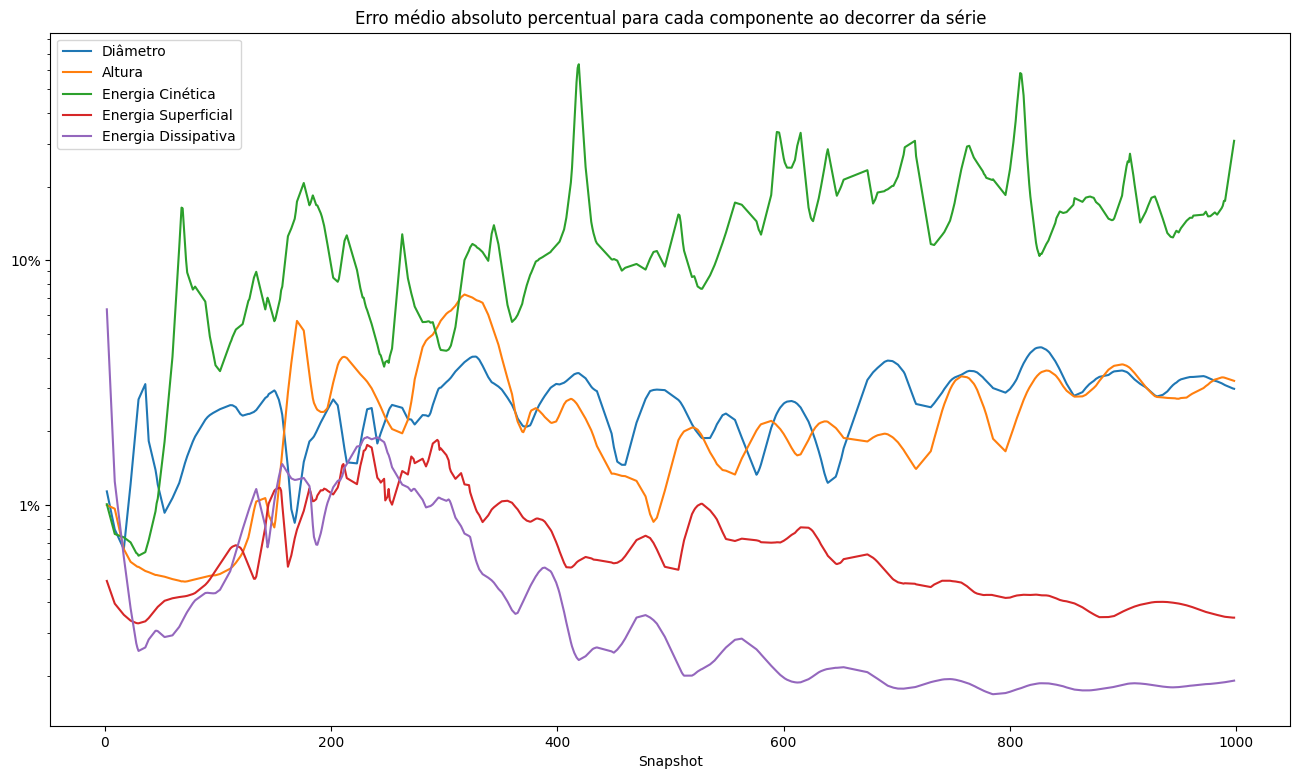

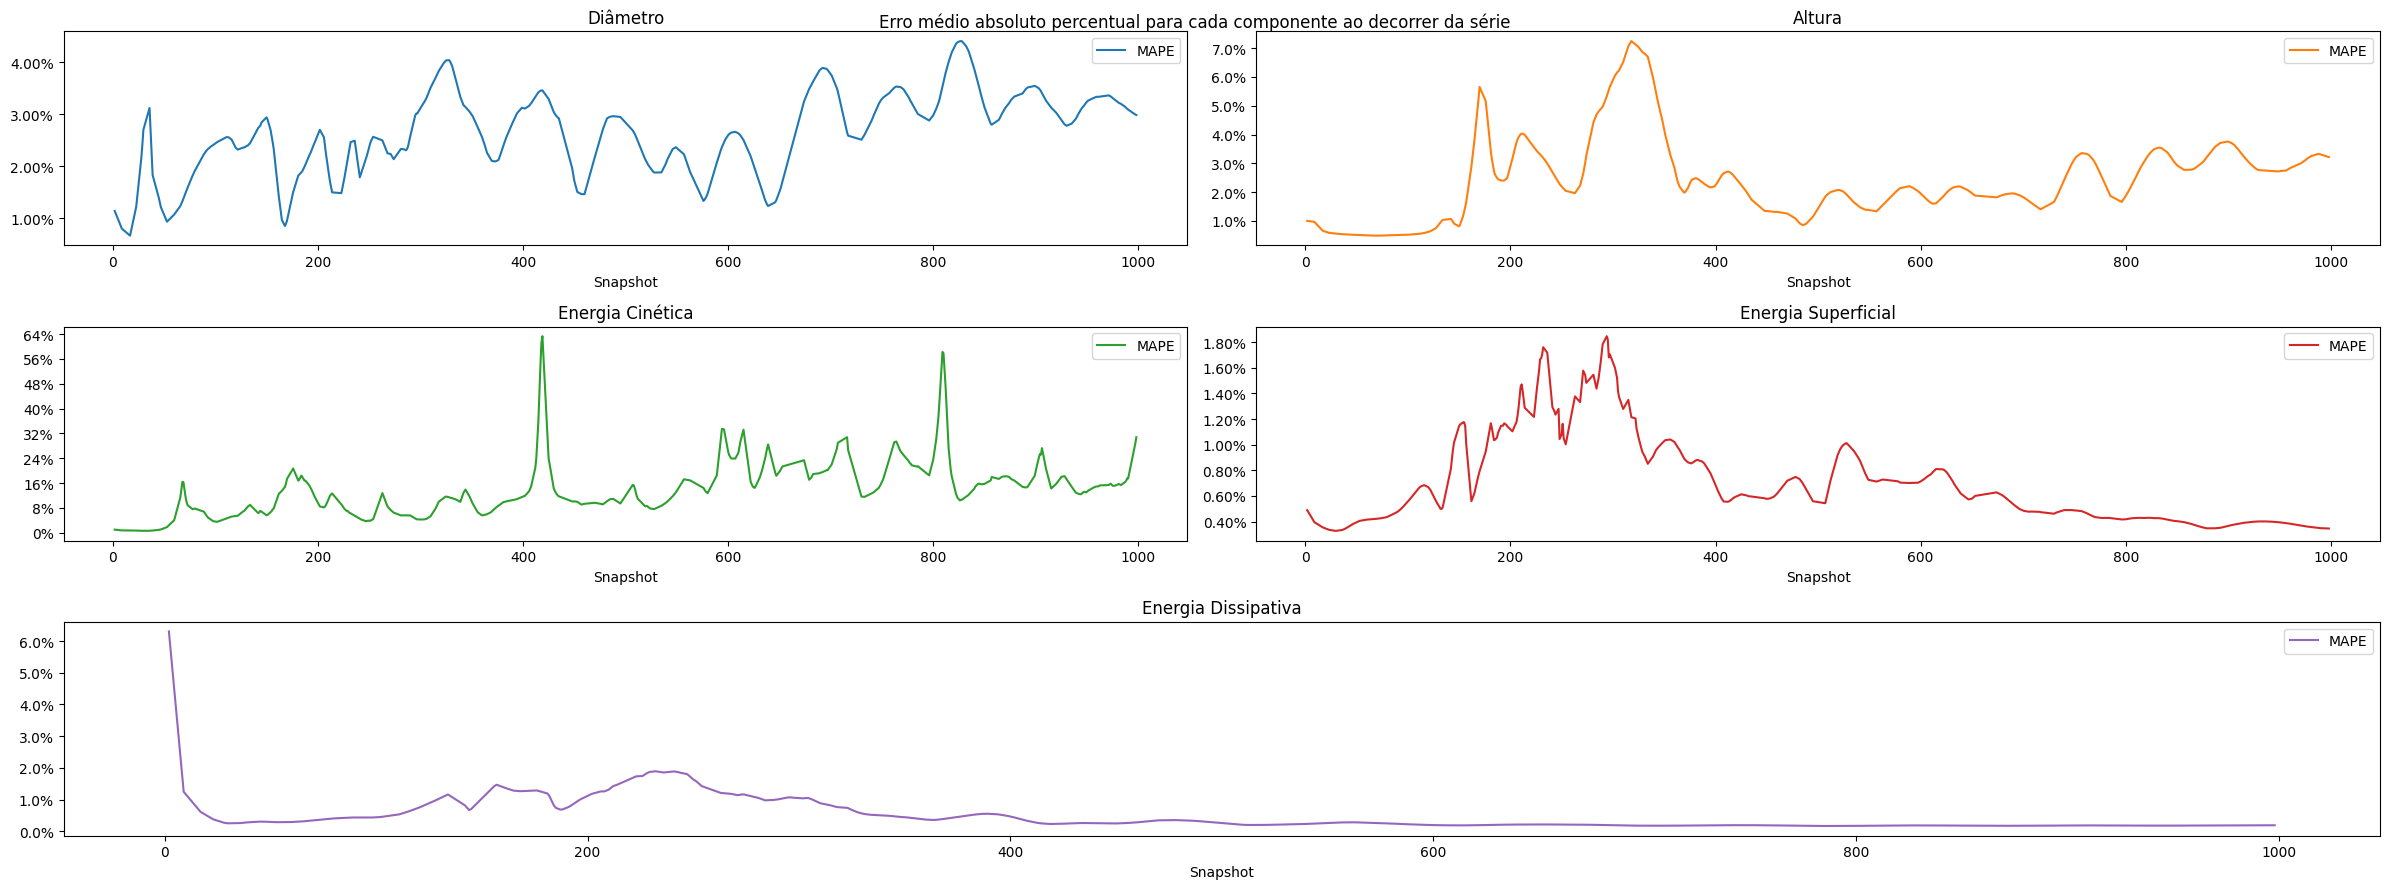

In [11]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.ticker import MaxNLocator, PercentFormatter

fig_general, ax_general = plt.subplots(figsize=(16,9))
ax_general.set_yscale("log")
ax_general.yaxis.set_major_formatter(PercentFormatter())

fig_subs = plt.figure(figsize=(24,9))
gs = fig_subs.add_gridspec(3, 2)

for k, cmpnt in enumerate(components_idx):
    i = k // 2
    j = k % 2
    if i < 2:
        ax_sub = fig_subs.add_subplot(gs[i, j])
    else:
        ax_sub = fig_subs.add_subplot(gs[i, :])
    results["collision"]["autoencoder"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_general, label=cmpnt)
    color = ax_general.get_lines()[-1].get_color()
    results["collision"]["autoencoder"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_sub, color=color)
    ax_sub.set_title(cmpnt)
    ax_sub.legend()
    ax_sub.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_sub.yaxis.set_major_formatter(PercentFormatter())
ax_general.legend()
ax_general.set_title('Erro médio absoluto percentual para cada componente ao decorrer da série')
fig_general.savefig('.results/pytorch/mape_autoencoder_collision_all.png', dpi=300)
fig_subs.tight_layout()
fig_subs.suptitle('Erro médio absoluto percentual para cada componente ao decorrer da série')
fig_subs.savefig('.results/pytorch/mape_autoencoder_collision_subplots.png', dpi=300)

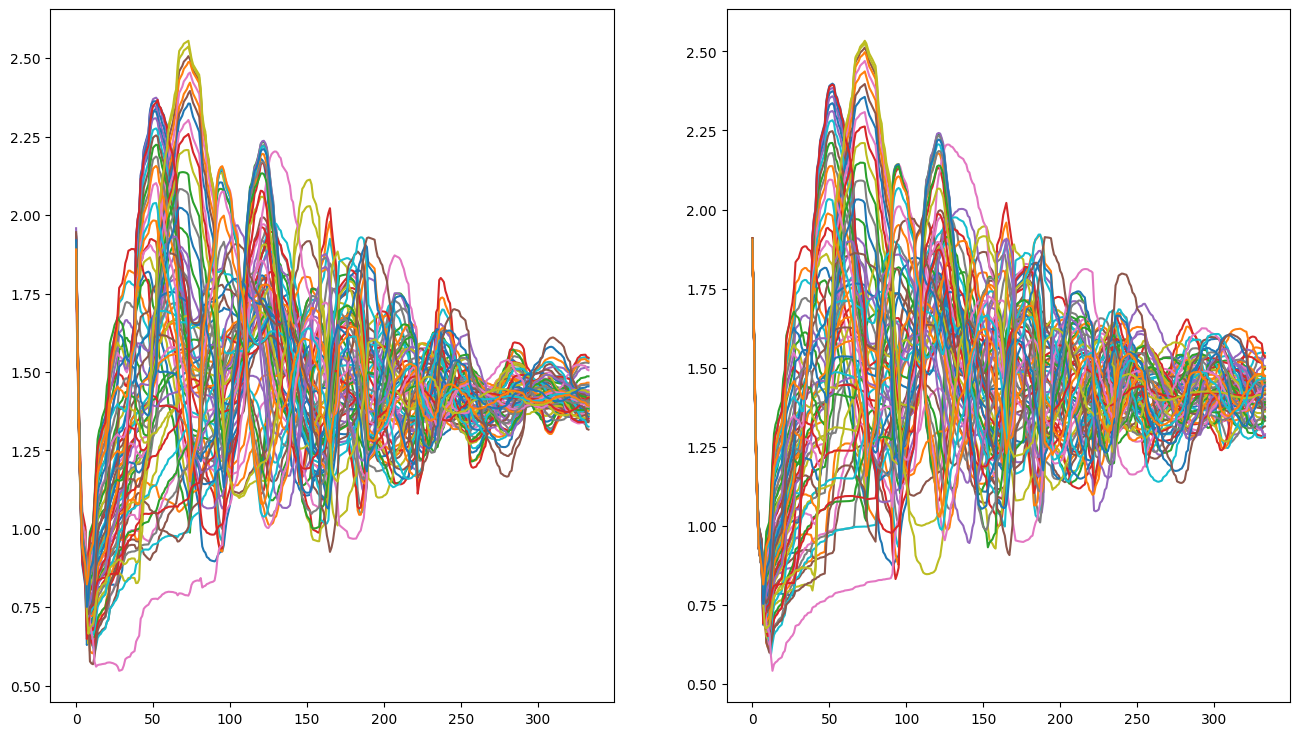

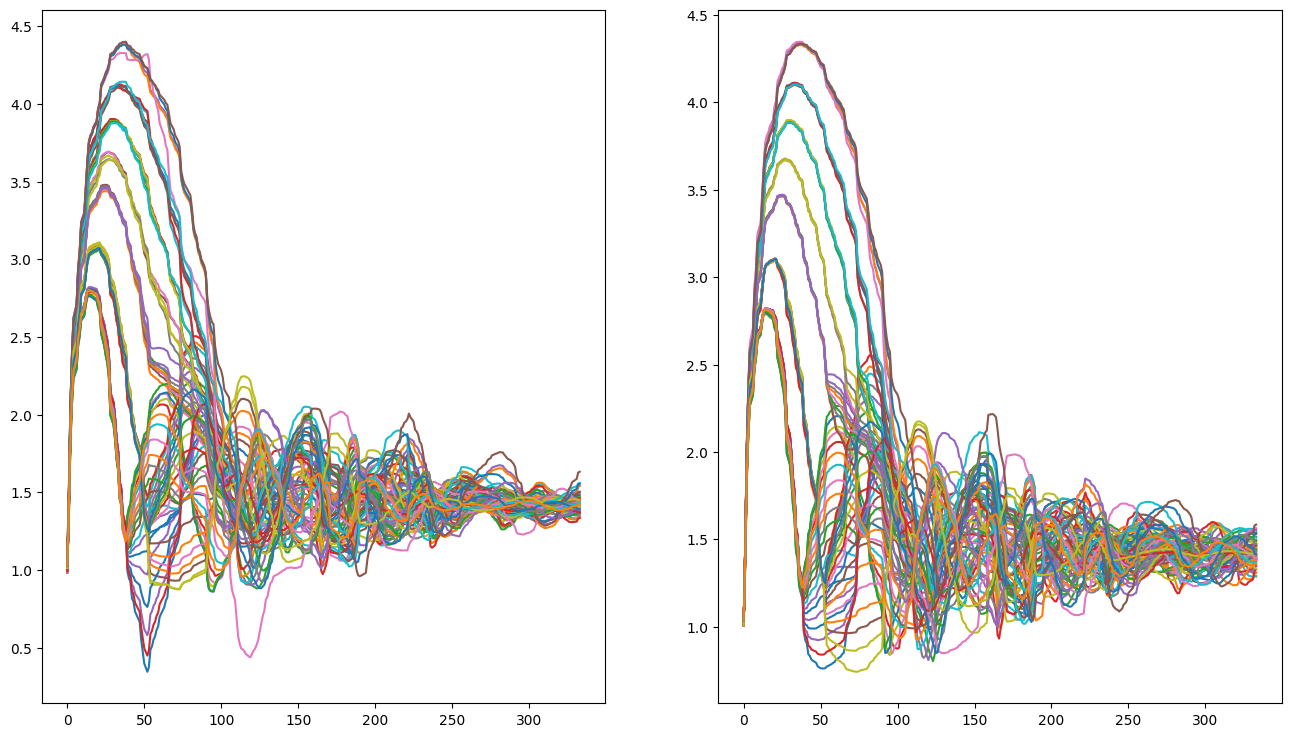

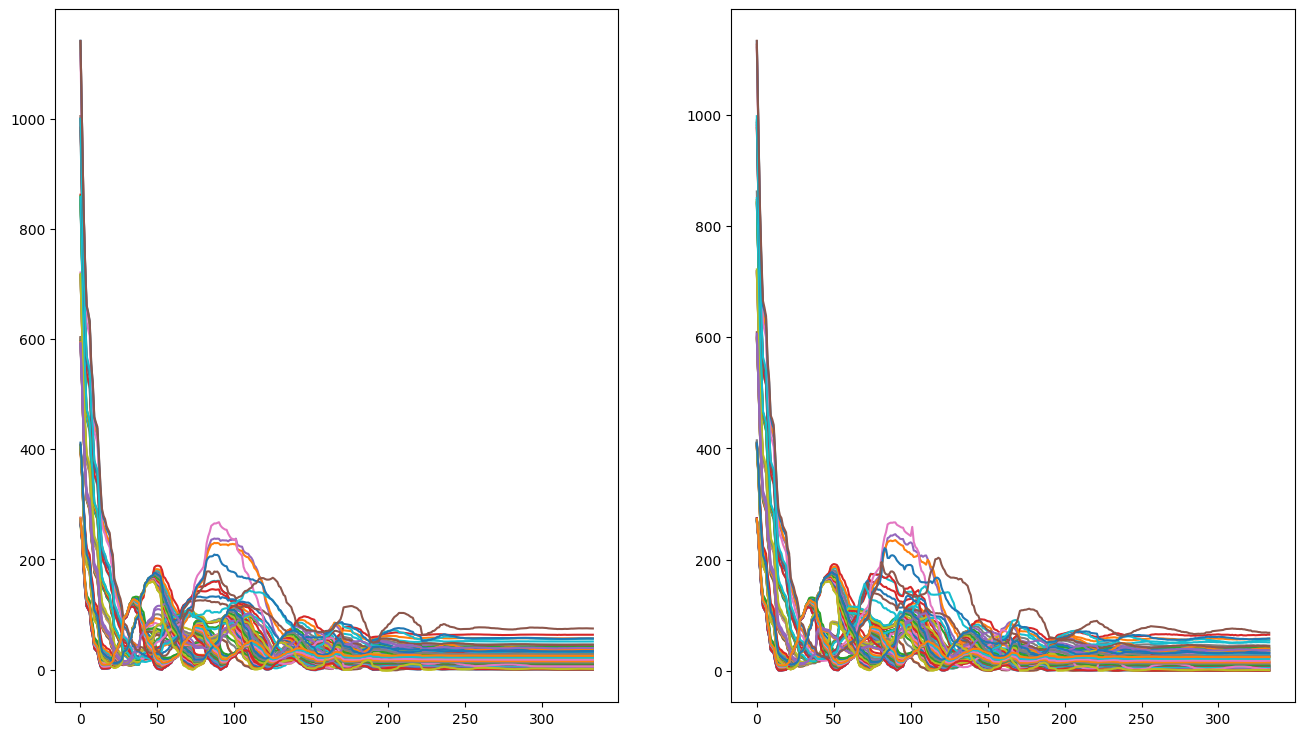

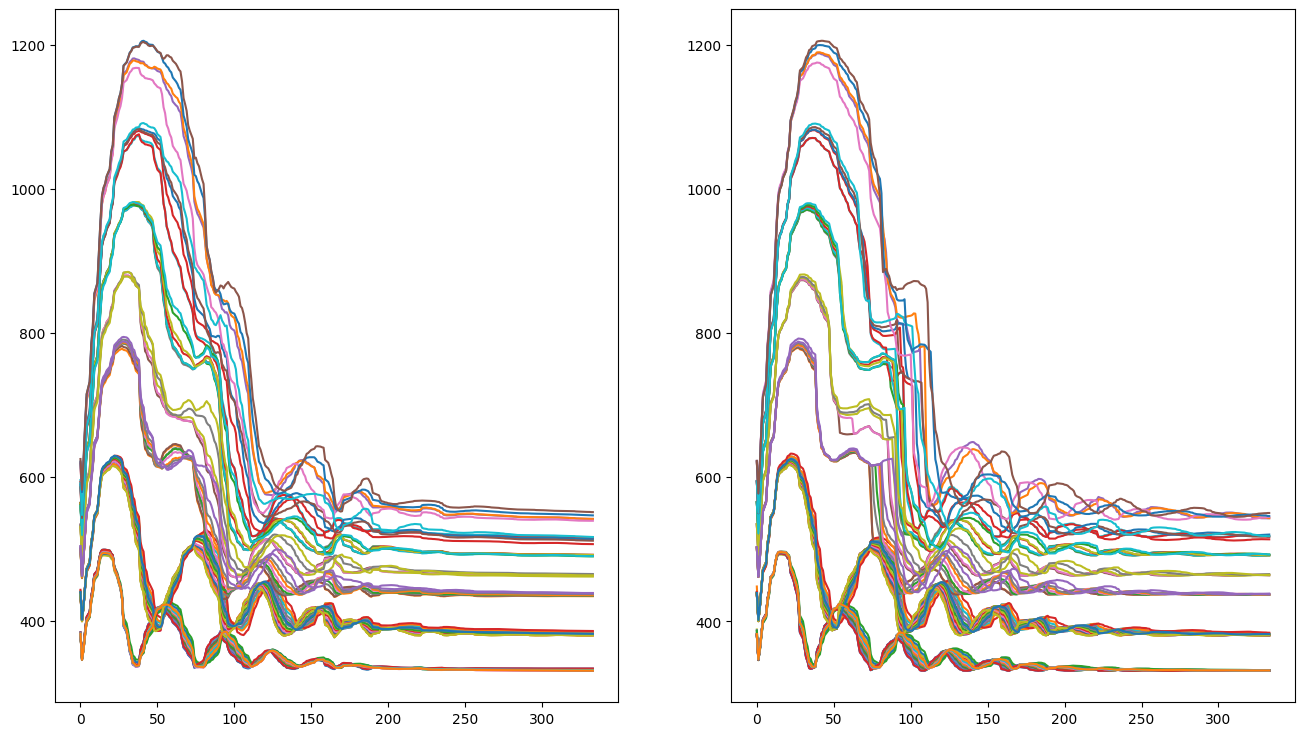

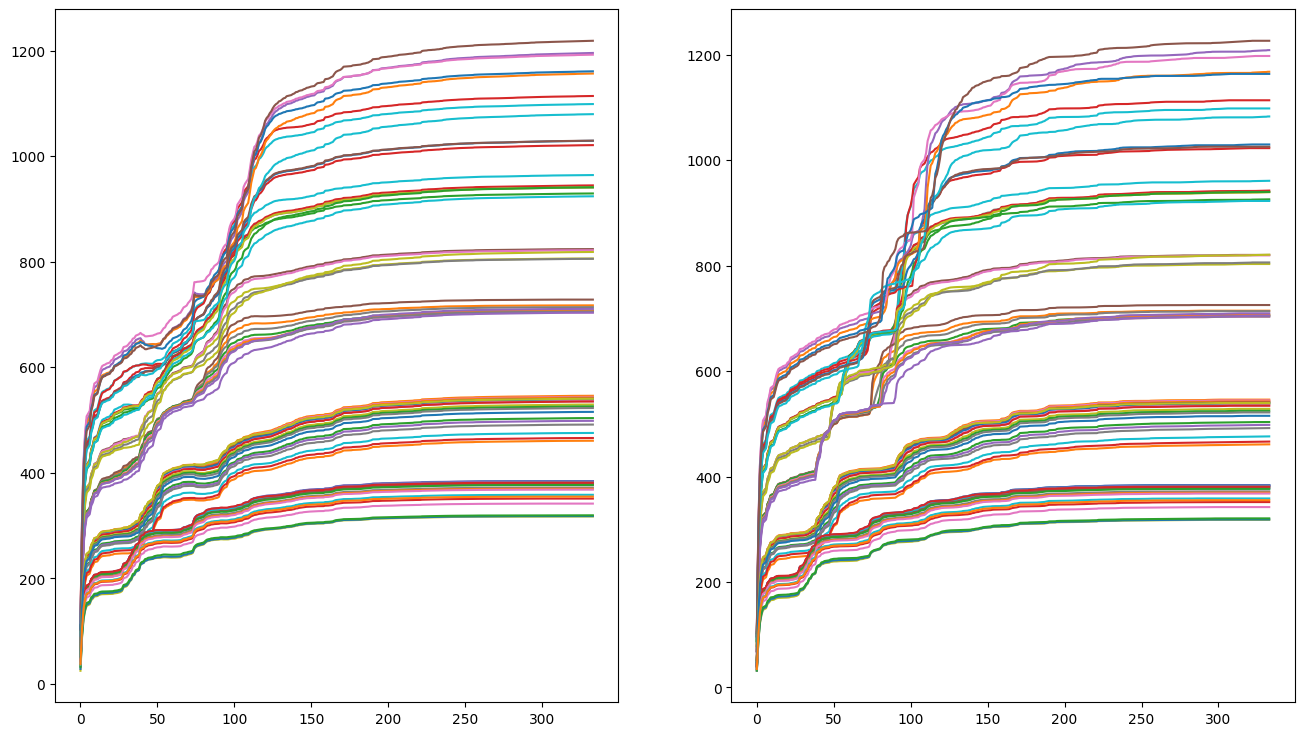

In [12]:
for component in components_collision:
    #argsort each prediction according to permutation_idx
    fig, axs = plt.subplots(1, 2, figsize=(16, 9))
    to_be_plotted = component["autoencoder"]["prediction_unscaled"][np.argsort(permutation_idx[666:])]
    comparison_plot = component["autoencoder"]["testing_data_unscaled"][np.argsort(permutation_idx[666:])]
    axs[0].plot(to_be_plotted)
    axs[1].plot(comparison_plot)
    plt.show()

## Abordagem 2: PCA

Tendo em vista que o Autoencoder desempenhou melhor quando usando funções de ativação lineares, uma hipótese é que o PCA pode ser um método bastante competitivo nesse caso.

In [13]:
from sklearn.decomposition import PCA

for component in components_collision:
    # Using same encoding dim: 9
    pca = PCA(n_components=9)
    pca.fit(component["autoencoder"]["training_data"])
    reconstructed = pca.inverse_transform(pca.transform(component["autoencoder"]["testing_data_scaled"]))
    unscaled = component["autoencoder"]["scaler"].inverse_transform(reconstructed)
    component["pca"] = {
        "model": pca,
        "prediction_scaled": reconstructed,
        "prediction_unscaled": unscaled,
        "testing_data_unscaled": component["autoencoder"]["testing_data_unscaled"]
    }

In [14]:
columns = pd.MultiIndex.from_product([['MSE', 'MAPE'], ['min', 'max', 'mean']])
data = np.zeros((5, 6))
result_df = pd.DataFrame(
    data,
    index=pd.RangeIndex(0, 5, name="Component"),
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    component["pca"]["mse_loss"] =\
        mean_squared_error(component["pca"]["testing_data_unscaled"], component["pca"]["prediction_unscaled"])
    component["pca"]["mape_loss"] =\
        mean_absolute_percentage_error(component["pca"]["testing_data_unscaled"], component["pca"]["prediction_unscaled"])
    result_df.loc[cmpnt, ("MSE", "min")] = np.min(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "max")] = np.max(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MSE", "mean")] = np.mean(component["pca"]["mse_loss"])
    result_df.loc[cmpnt, ("MAPE", "min")] = np.min(component["pca"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "max")] = np.max(component["pca"]["mape_loss"])
    result_df.loc[cmpnt, ("MAPE", "mean")] = np.mean(component["pca"]["mape_loss"])

results = {
    "collision": {
        "pca": {
            "stats": result_df
        }
    }
}

display("Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente")
display(results["collision"]["pca"]["stats"])

'Distribuição de erros quadráticos médios e erro médio absoluto percentual para cada componente'

MSE                    MAPE                
             min      max    mean    min     max    mean
Component                                               
0         0.0002   0.0056  0.0026 0.7625  4.3812  2.7709
1         0.0000   0.0073  0.0028 0.1002  4.3188  2.5247
2         0.7500  83.7046 12.7800 0.2136 81.5047 15.7732
3         0.6706 179.4703 26.6690 0.0792  1.3013  0.4906
4         0.1335  43.0138  5.7865 0.0404  3.9877  0.1967

In [15]:
components_idx = pd.Index(["Diâmetro", "Altura", "Energia Cinética", "Energia Superficial", "Energia Dissipativa"], name="Componente")
snapshots_idx = pd.Index(permutation_idx[666:], name="Snapshot")
columns = ["MSE", "MAPE"]
data = np.zeros((5 * 334, 2))

index = pd.MultiIndex.from_product([components_idx, snapshots_idx])
detailed_result_df = pd.DataFrame(
    data,
    index=index,
    columns=columns
)

for cmpnt, component in enumerate(components_collision):
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MSE"] = np.array(component["pca"]["mse_loss"])
    detailed_result_df.loc[(components_idx[cmpnt], slice(None)), "MAPE"] = np.array(component["pca"]["mape_loss"])

results["collision"]["pca"]["detailed_stats"] = detailed_result_df

display("Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep")
display(results["collision"]["pca"]["detailed_stats"])

'Erros quadráticos médios e erro médio absoluto percentual para cada componente e timestep'

MSE   MAPE
Componente          Snapshot               
Diâmetro            689       0.0039 3.2352
                    156       0.0016 2.4082
                    369       0.0018 2.0530
                    557       0.0016 2.3641
                    399       0.0021 2.1970
...                              ...    ...
Energia Dissipativa 757       0.4332 0.0525
                    431       7.9220 0.2545
                    402       5.3071 0.2293
                    382      10.2476 0.3513
                    824       0.4046 0.0495

[1670 rows x 2 columns]

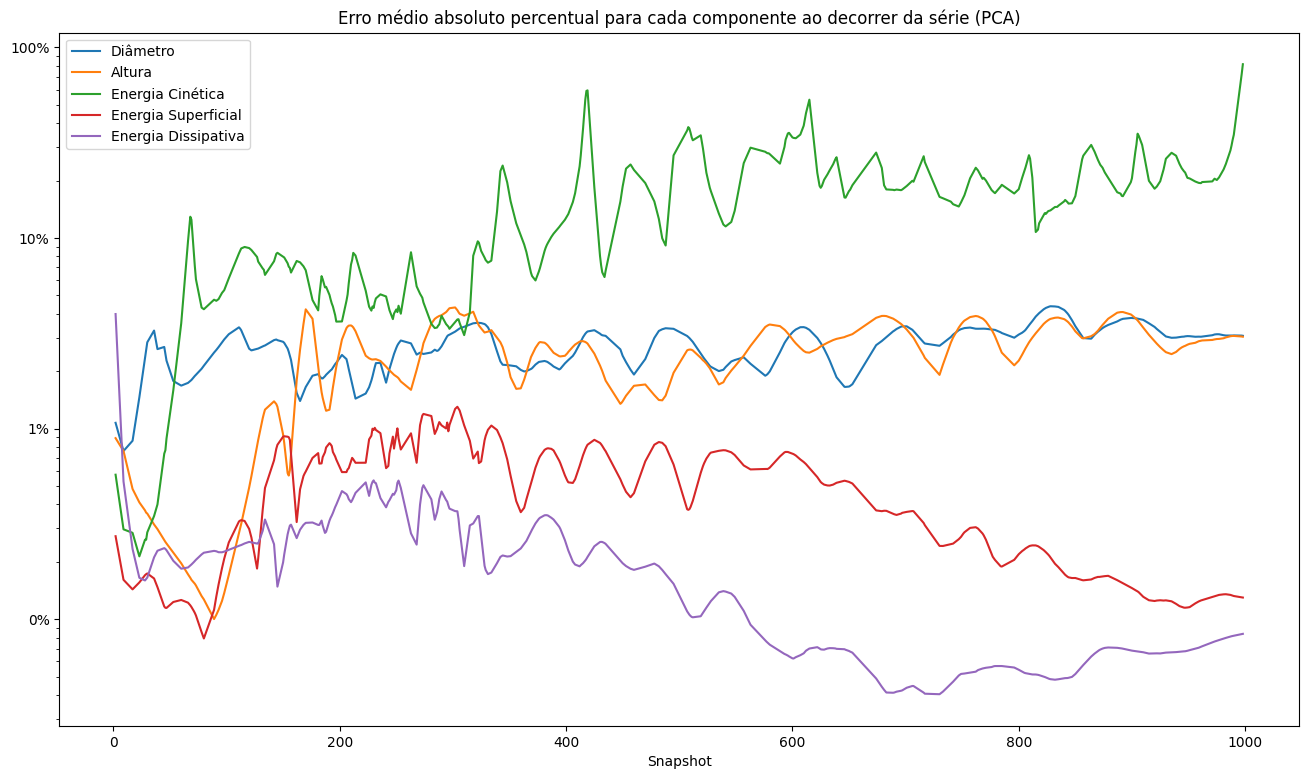

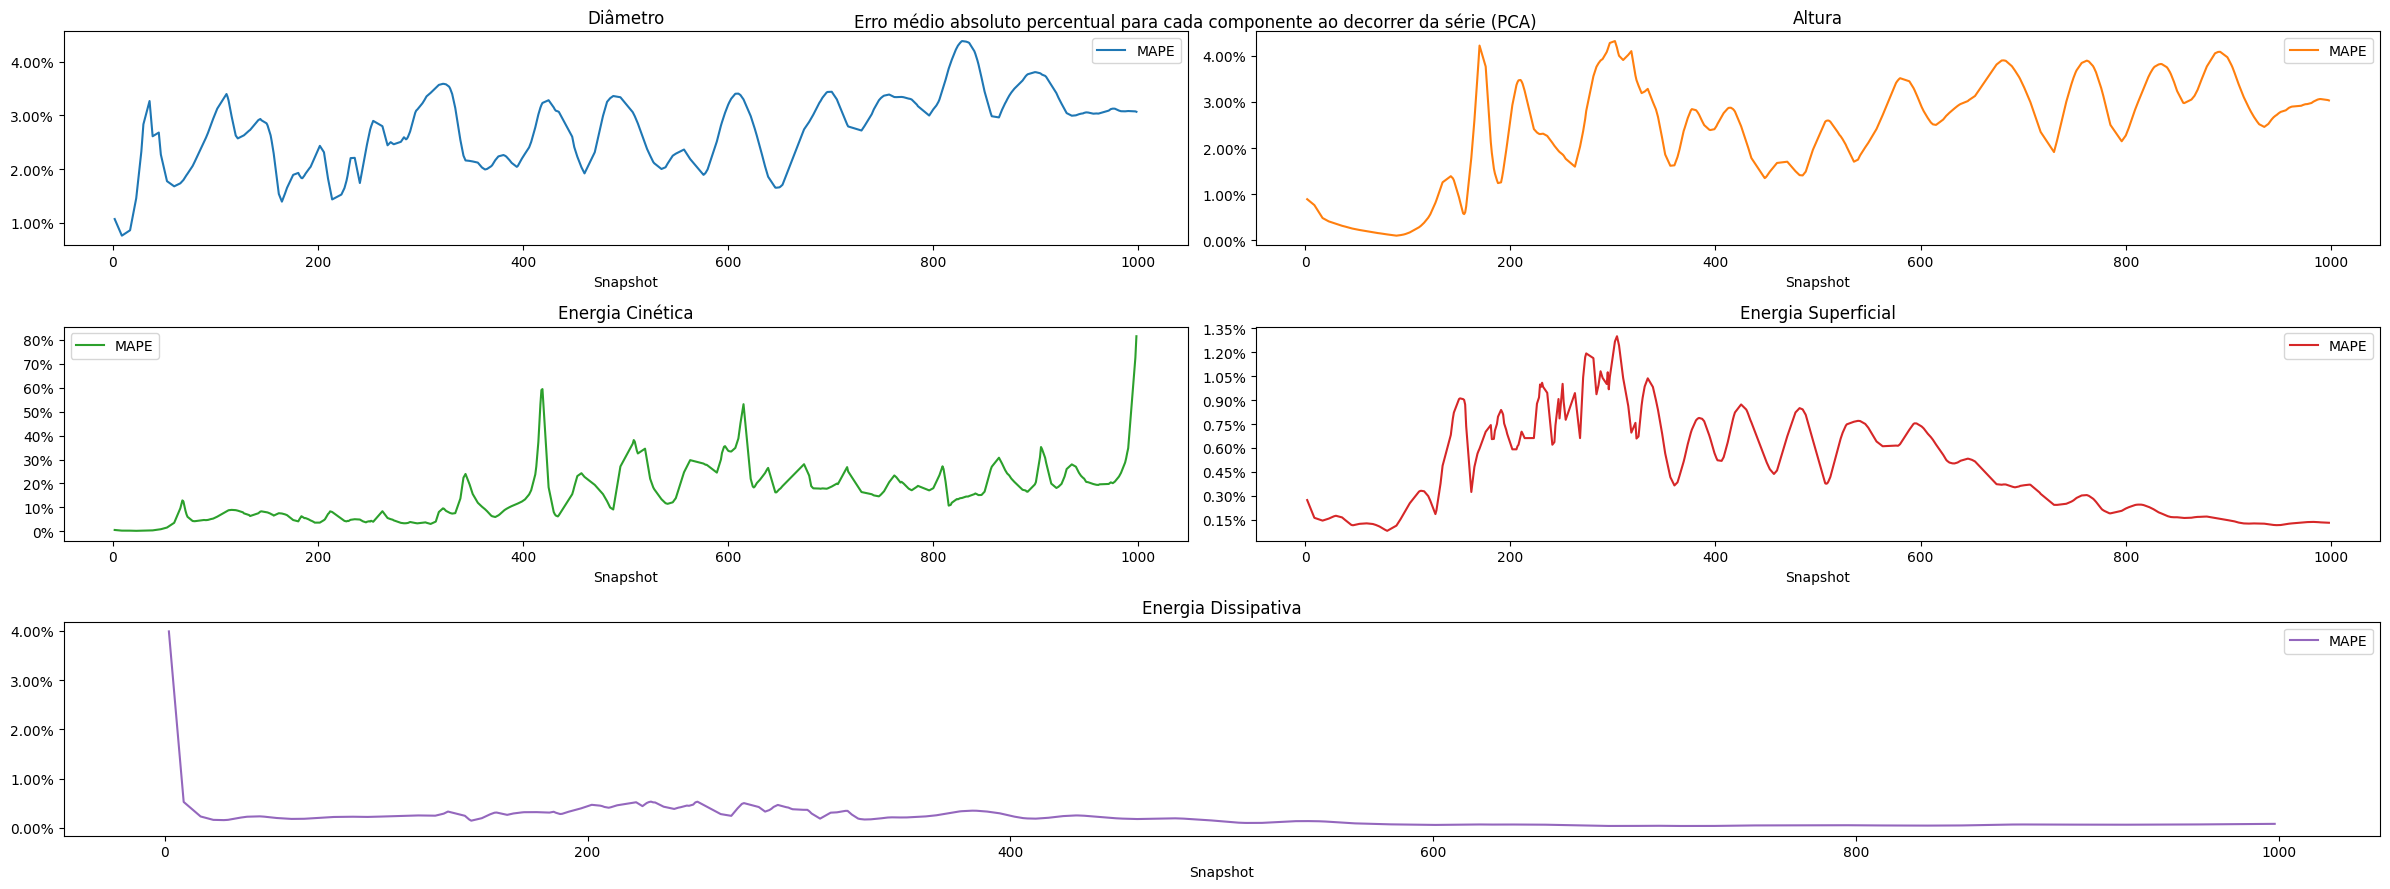

In [16]:
fig_general, ax_general = plt.subplots(figsize=(16,9))
ax_general.set_yscale("log")
ax_general.yaxis.set_major_formatter(PercentFormatter())

fig_subs = plt.figure(figsize=(24,9))
gs = fig_subs.add_gridspec(3, 2)

for k, cmpnt in enumerate(components_idx):
    i = k // 2
    j = k % 2
    if i < 2:
        ax_sub = fig_subs.add_subplot(gs[i, j])
    else:
        ax_sub = fig_subs.add_subplot(gs[i, :])
    results["collision"]["pca"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_general, label=cmpnt)
    color = ax_general.get_lines()[-1].get_color()
    results["collision"]["pca"]["detailed_stats"].loc[(cmpnt), "MAPE"].sort_index().plot(ax=ax_sub, color=color)
    ax_sub.set_title(cmpnt)
    ax_sub.legend()
    ax_sub.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax_sub.yaxis.set_major_formatter(PercentFormatter())
ax_general.legend()
ax_general.set_title('Erro médio absoluto percentual para cada componente ao decorrer da série (PCA)')
fig_general.savefig('.results/mape_pca_collision_all.png', dpi=300)
fig_subs.tight_layout()
fig_subs.suptitle('Erro médio absoluto percentual para cada componente ao decorrer da série (PCA)')
fig_subs.savefig('.results/mape_pca_collision_subplots.png', dpi=300)

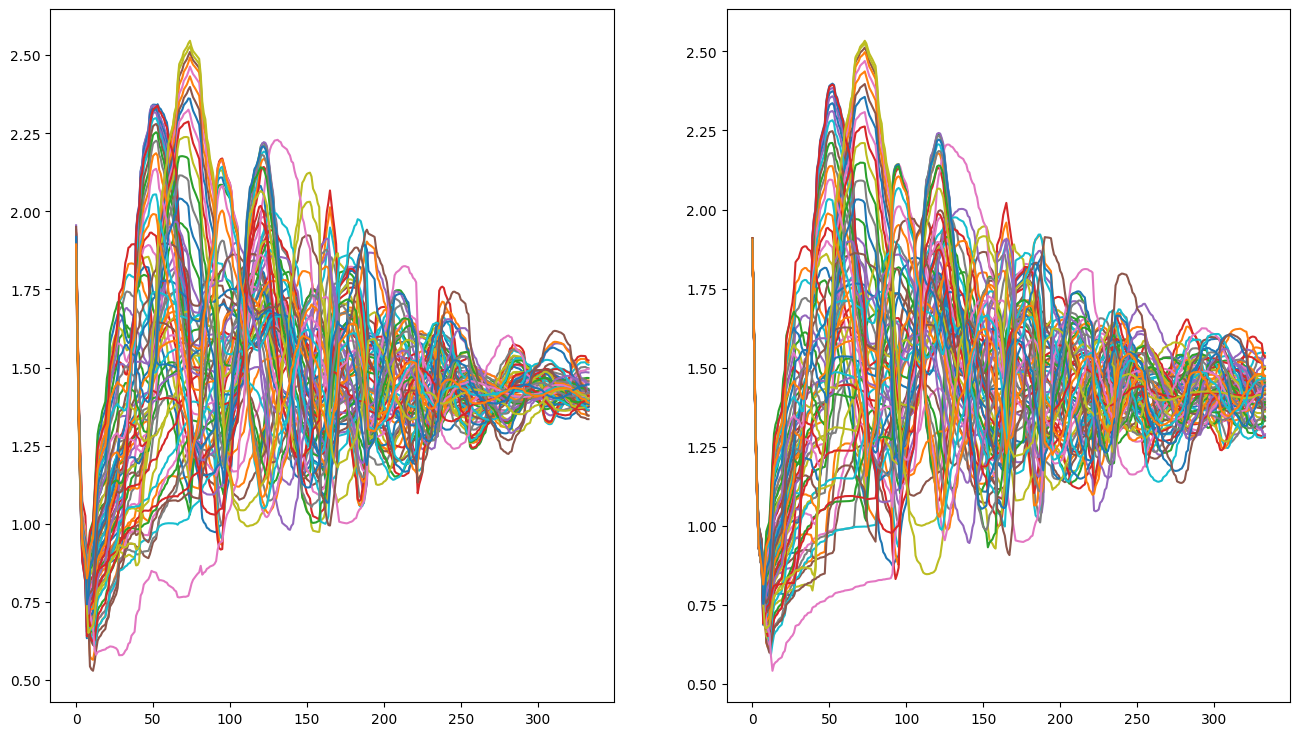

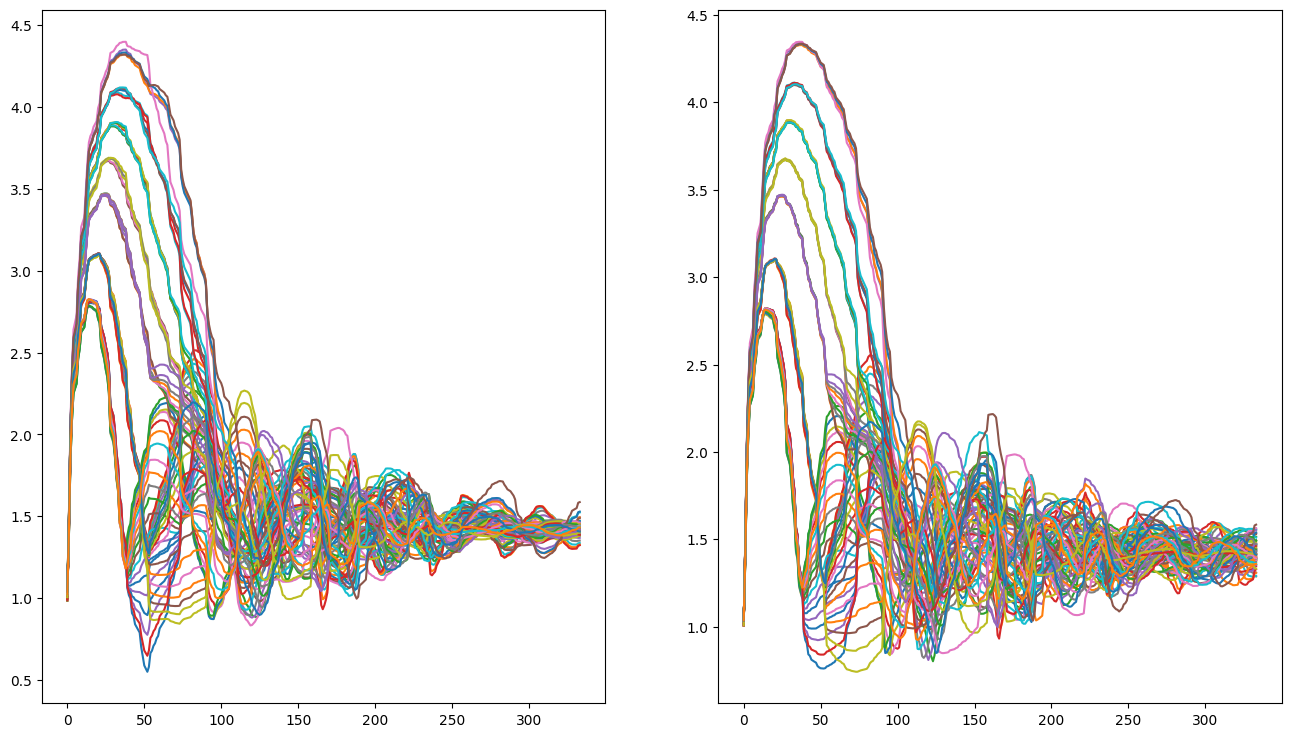

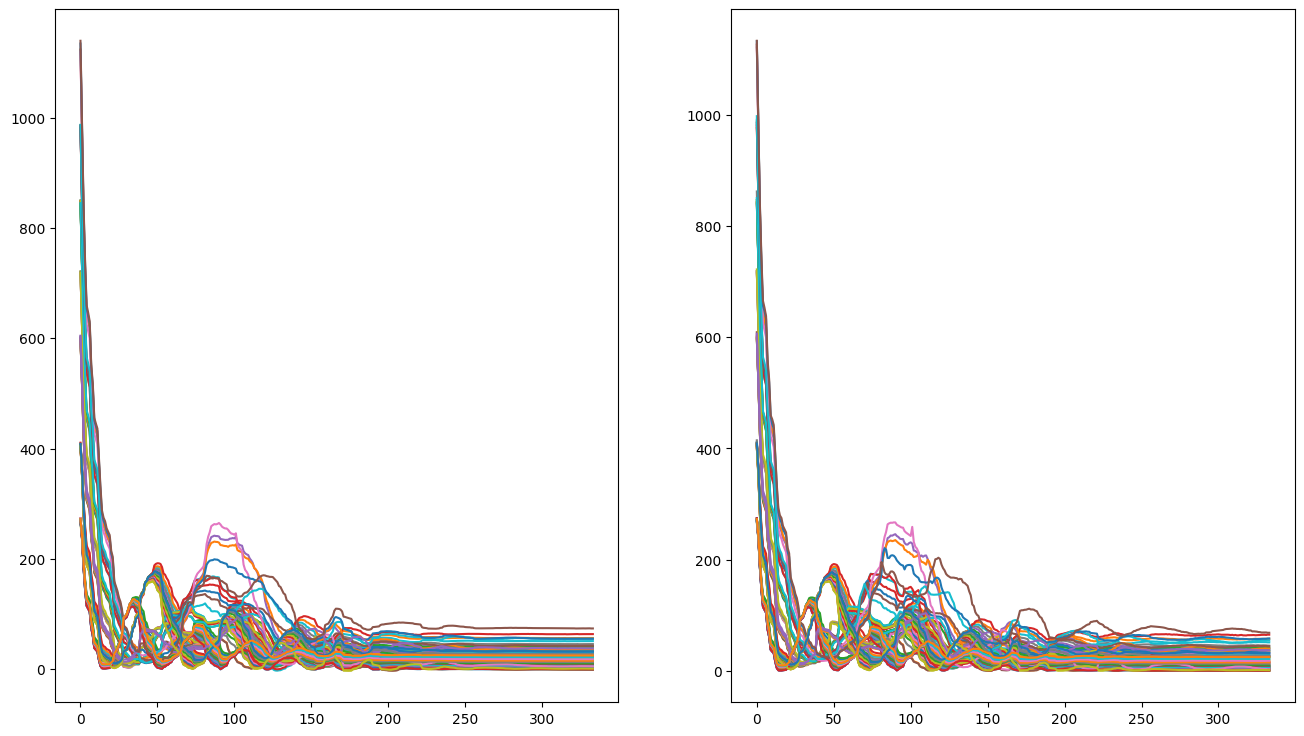

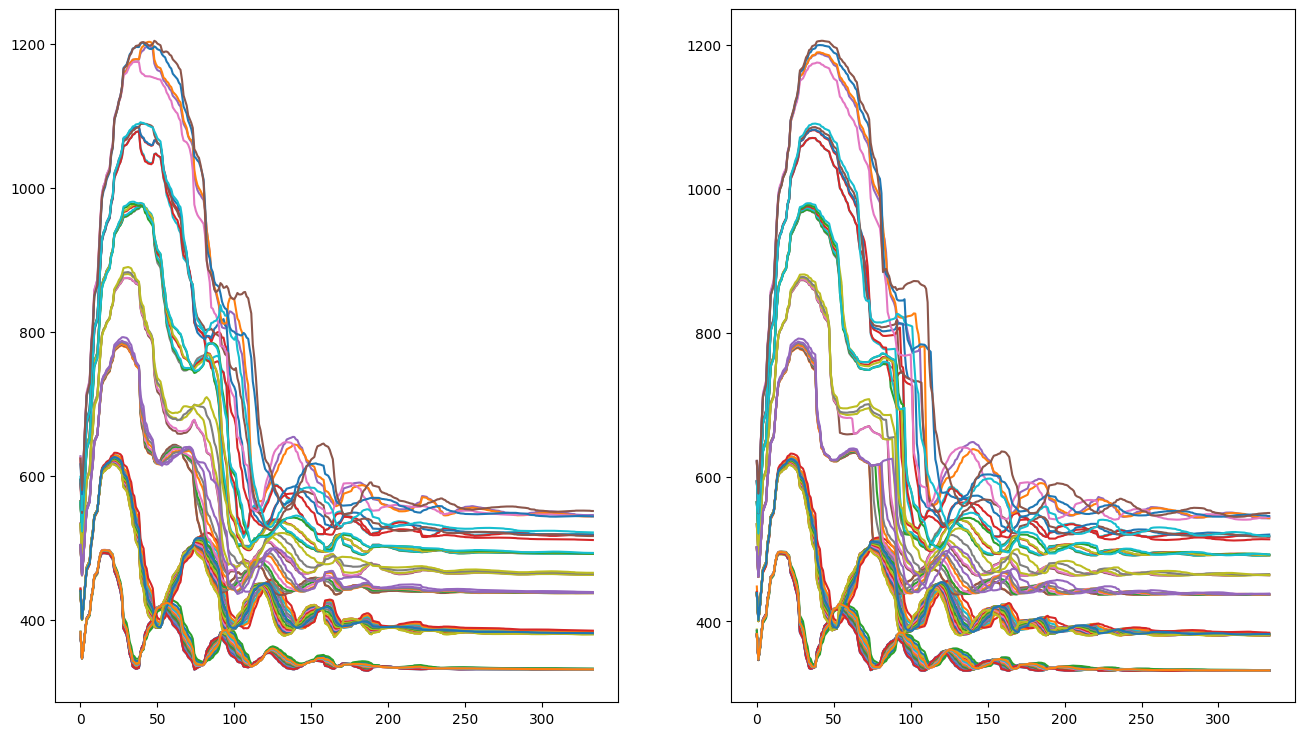

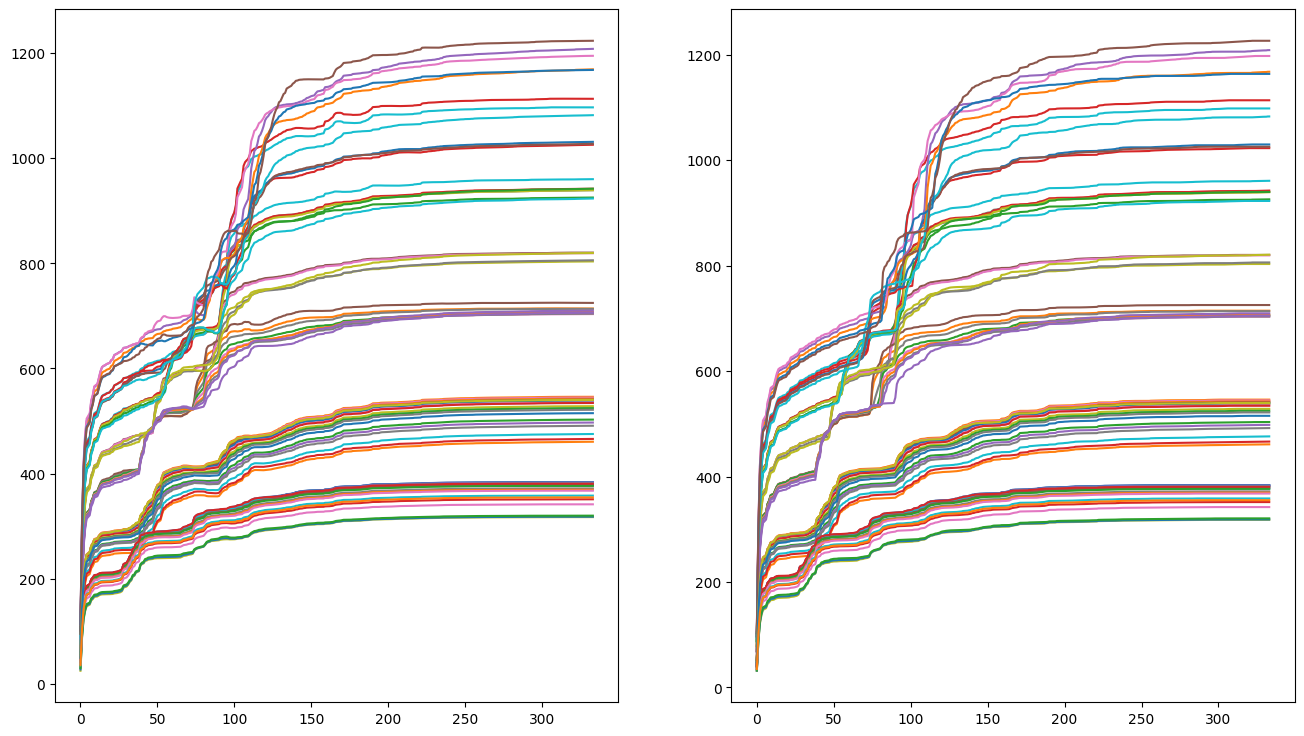

In [17]:
for component in components_collision:
    #argsort each prediction according to permutation_idx
    fig, axs = plt.subplots(1, 2, figsize=(16, 9))
    to_be_plotted = component["pca"]["prediction_unscaled"][np.argsort(permutation_idx[666:])]
    comparison_plot = component["pca"]["testing_data_unscaled"][np.argsort(permutation_idx[666:])]
    axs[0].plot(to_be_plotted)
    axs[1].plot(comparison_plot)
    plt.show()

##### Demonstrating that this transpose makes sense

In [ ]:
# Let's test if this is correct
# Suppose we have tree simulations with 2 components each
# We have 3 timesteps
# First component is linear, second is quadratic
# First simulation starts with 1
# Second simulation starts with 2
# Third simulation starts with 3
# Therefore, first simulation first component is [1, 2, 3]
# Second simulation first component is [2, 3, 4]
# Third simulation first component is [3, 4, 5]
# First simulation second component is [1, 4, 9]
# Second simulation second component is [4, 9, 16]
# Third simulation second component is [9, 16, 25]
# Therefore, first timestep is [[1, 2, 3], [1, 4, 9]]
first_simulation = np.array([[1, 1], [2, 4], [3, 9]])
second_simulation = np.array([[2, 4], [3, 9], [4, 16]])
third_simulation = np.array([[3, 9], [4, 16], [5, 25]])
timesteps = np.array([first_simulation, second_simulation, third_simulation])
shape = timesteps.shape
display(shape)
transformed_timesteps = timesteps.transpose(1, 0, 2).reshape(shape[1], shape[0] * shape[2])
display(transformed_timesteps)